In [3]:

pip install --upgrade pip setuptools


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install labelme tensorflow-macos opencv-python matplotlib albumentations


Note: you may need to restart the kernel to use updated packages.


In [8]:


import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.3.1-arm64-arm-64bit
Tensor Flow Version: 2.16.1
Keras Version: 3.3.3

Python 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.4.2
SciPy 1.13.0
GPU is available


In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [10]:
import os
import time
import uuid
import cv2

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [14]:
images.as_numpy_iterator().next()

b'data/images/da78d414-9f4d-11ee-8b88-6ebfc81b5168.jpg'

In [15]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
images = images.map(load_image)


In [17]:
images.as_numpy_iterator().next()

array([[[224, 224, 214],
        [225, 225, 215],
        [225, 225, 215],
        ...,
        [178, 175, 166],
        [178, 175, 166],
        [179, 176, 167]],

       [[225, 225, 215],
        [225, 225, 215],
        [225, 225, 215],
        ...,
        [181, 178, 169],
        [180, 177, 168],
        [179, 176, 167]],

       [[227, 227, 217],
        [226, 226, 216],
        [226, 226, 216],
        ...,
        [183, 180, 171],
        [181, 178, 169],
        [179, 176, 167]],

       ...,

       [[144, 147, 136],
        [183, 186, 175],
        [190, 193, 182],
        ...,
        [ 94,  87,  81],
        [ 96,  89,  83],
        [ 97,  90,  84]],

       [[174, 177, 166],
        [191, 194, 183],
        [189, 192, 181],
        ...,
        [ 87,  80,  74],
        [ 88,  81,  75],
        [100,  93,  87]],

       [[179, 182, 171],
        [181, 184, 173],
        [189, 192, 181],
        ...,
        [ 88,  81,  75],
        [ 93,  86,  80],
        [ 95,  88,  82]]

In [18]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [19]:
image_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = image_generator.next()

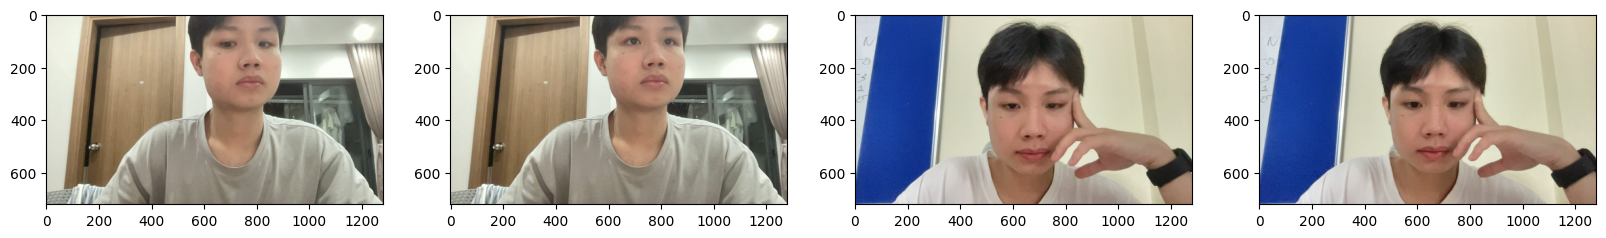

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [22]:
90*.7 # 63 to train

62.99999999999999

In [23]:

90*.15 # 14 and 13 to test and val

13.5

In [24]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

In [46]:
import albumentations as alb
from albumentations.pytorch import ToTensorV2


In [30]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [31]:
img = cv2.imread(os.path.join('data','train', 'images','b09bb688-9e40-11ee-9c61-6ebfc81b5168.jpg'))


In [39]:
height, width = img.shape[:2]

In [32]:
with open(os.path.join('data', 'train', 'labels', 'b09bb688-9e40-11ee-9c61-6ebfc81b5168.json'), 'r') as f:
    label = json.load(f)

In [33]:
label['shapes'][0]['points']

[[895.7692307692307, 613.8461538461538], [434.4314381270903, 0.0]]

In [40]:
coords = label['shapes'][0]['points']
x_min = coords[0][0]
y_min = coords[0][1]
x_max = coords[1][0]
y_max = coords[1][1]

In [57]:
normalized_coords = [
    min(x_min, x_max) / width,
    min(y_min, y_max) / height,
    max(x_min, x_max) / width,
    max(y_min, y_max) / height
]

In [58]:
augmentor = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    # Add other augmentations here if needed
    alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


In [59]:
coords

[[895.7692307692307, 613.8461538461538], [434.4314381270903, 0.0]]

In [60]:
# Print normalized coordinates
print("Normalized Coordinates:", normalized_coords)

# Verify that x_max is greater than x_min
if normalized_coords[2] <= normalized_coords[0]:
    raise ValueError(f"x_max is less than or equal to x_min: {normalized_coords}")

# Verify that y_max is greater than y_min
if normalized_coords[3] <= normalized_coords[1]:
    raise ValueError(f"y_max is less than or equal to y_min: {normalized_coords}")

Normalized Coordinates: [0.3393995610367893, 0.0, 0.6998197115384615, 0.8525641025641025]


In [62]:
augmented = augmentor(image=img, bboxes=[normalized_coords], class_labels=['face'])


In [63]:
augmented['bboxes'][0][2:]

(0.6998197115384615, 0.8525641025641025)

In [64]:
augmented['bboxes']

[(0.3393995610367893, 0.0, 0.6998197115384615, 0.8525641025641025)]

In [66]:
augmented_img_numpy = augmented['image'].permute(1, 2, 0).cpu().numpy()


In [67]:
cv2.rectangle(augmented_img_numpy, 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)), 
              (255, 0, 0), 2)


array([[[ 1.6666666 ,  1.6757703 ,  1.8208278 ],
        [ 1.6324171 ,  1.6407562 ,  1.7859695 ],
        [ 1.6837913 ,  1.6932772 ,  1.8382571 ],
        ...,
        [ 0.82755363,  1.4306722 ,  1.8556863 ],
        [ 0.82755363,  1.4481792 ,  1.8382571 ],
        [ 0.7419299 ,  1.3606442 ,  1.7511111 ]],

       [[ 1.6324171 ,  1.6407562 ,  1.7859695 ],
        [ 1.5810428 ,  1.5882353 ,  1.7336819 ],
        [ 1.6666666 ,  1.6757703 ,  1.8208278 ],
        ...,
        [ 0.89605266,  1.5007002 ,  1.925403  ],
        [ 0.9303022 ,  1.5532212 ,  1.9428322 ],
        [ 0.91317743,  1.5357143 ,  1.925403  ]],

       [[ 1.6666666 ,  1.6757703 ,  1.8208278 ],
        [ 1.6152923 ,  1.6232492 ,  1.7685403 ],
        [ 1.6495419 ,  1.6582632 ,  1.8033987 ],
        ...,
        [ 0.8104289 ,  1.4131652 ,  1.8382571 ],
        [ 0.8618032 ,  1.4656862 ,  1.8905447 ],
        [ 0.89605266,  1.5007002 ,  1.925403  ]],

       ...,

       [[ 0.34806055, -0.757703  , -1.1072767 ],
        [ 0

In [68]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected x_min for bbox [1.3091755319148937, 1.2442375886524821, 0.6409574468085106, 0.16710992907801422, 'face'] to be in the range [0.0, 1.0], got 1.3091755319148937.
Expected x_min for bbox [1.382313829787234, 1.2398049645390072, 0.6708776595744681, 0.025265957446808564, 'face'] to be in the range [0.0, 1.0], got 1.382313829787234.
OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'

Expected x_min for bbox [1.399639423076923, 1.2788461538461537, 0.6787991220735786, 0.0, 'face'] to be in the range [0.0, 1.0], got 1.399639423076923.
OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'

Expected x_min for bbox [1.3575721153846154, 1.2708333333333333, 0.6965144230769231, 0.04487179487179489, 'face'] to be in the r

In [70]:
train_images = tf.data.Dataset.list_files('data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [71]:
test_images = tf.data.Dataset.list_files('data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [72]:
val_images = tf.data.Dataset.list_files('data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [73]:
train_images.as_numpy_iterator().next()

array([[[0.86764705, 0.86764705, 0.82843137],
        [0.8617647 , 0.8656863 , 0.82058823],
        [0.8732026 , 0.8732026 , 0.8261438 ],
        ...,
        [0.6702615 , 0.6741831 , 0.6545752 ],
        [0.6666667 , 0.6627451 , 0.64509803],
        [0.6669936 , 0.66307205, 0.6434642 ]],

       [[0.8683006 , 0.8683006 , 0.82908493],
        [0.86960787, 0.87352943, 0.8303922 ],
        [0.87647057, 0.87647057, 0.8372549 ],
        ...,
        [0.67091495, 0.6748365 , 0.6552287 ],
        [0.66862744, 0.672549  , 0.6509804 ],
        [0.6738559 , 0.66993433, 0.6503265 ]],

       [[0.8715686 , 0.8754902 , 0.84411764],
        [0.8745098 , 0.877451  , 0.85      ],
        [0.875817  , 0.875817  , 0.8366013 ],
        ...,
        [0.6745098 , 0.68235296, 0.6627451 ],
        [0.6813725 , 0.68921566, 0.66568625],
        [0.6918299 , 0.6957515 , 0.6722221 ]],

       ...,

       [[0.54869276, 0.55261433, 0.5212418 ],
        [0.5686275 , 0.5921569 , 0.5627451 ],
        [0.57614386, 0

In [74]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [75]:
train_labels = tf.data.Dataset.list_files('data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [77]:
# test_labels = tf.data.Dataset.list_files('data/test/labels/*.json', shuffle=False)
# test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# test_labels val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
# val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [78]:
train_labels.as_numpy_iterator().next()

2024-05-18 18:51:33.437389: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: KeyError: 'class'
Traceback (most recent call last):

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_97956/233515788.py", line 5, in load_labels
    return [label['class']], label['bbox']

KeyError: 'class'


2024-05-18 18:51:33.437521: W tensorflow/core/framework/local_rendezvous.cc:404] Local ren

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 'class'
Traceback (most recent call last):

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/Users/hephaestus/miniconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_97956/233515788.py", line 5, in load_labels
    return [label['class']], label['bbox']

KeyError: 'class'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 